In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
loan_train = pd.read_csv('Data/loan_train_sampled.csv')
loan_test = pd.read_csv('Data/loan_test.csv')

### Spliting the training data into labeled and unlabeled data

In [3]:
# Split labeled data into smaller labeled set and larger unlabeled set
labeled_data, unlabeled_data = train_test_split(loan_train, test_size=0.8, random_state=0)

# Separate test set for final evaluation
X_test = loan_test.loc[:, loan_test.columns != 'loan_status']


print("Labeled data shape:", labeled_data.shape)
print("Unlabeled data shape:", unlabeled_data.shape)

Labeled data shape: (3356, 39)
Unlabeled data shape: (13424, 39)


In [4]:
iteration = 0
train_accuracy = []
test_accuracy = []
train_error = []
test_error = []

### The model is trained on labeled data and the unlabeled data exhibiting high-confidence predictions (with high probabilities) with pseudo labels are added iteratively to the labeled data.

In [5]:
while len(unlabeled_data) > 10:
    print("\n------------------ Iteration:", iteration + 1 , "------------------")
    print("Labeled data Shape:", labeled_data.shape)
    print("Unlabeled data Shape:", unlabeled_data.shape)
    
    # Labeled data
    y_train_labeled = labeled_data['loan_status']
    X_train_labeled = labeled_data.loc[:, labeled_data.columns != 'loan_status']
    features = X_train_labeled.columns.tolist()
    
    # Encode categorical columns
    categorical_columns = X_train_labeled.select_dtypes(include=['object']).columns.tolist()
    encoder = ce.OrdinalEncoder(cols=categorical_columns)
    X_train_labeled = encoder.fit_transform(X_train_labeled)
    
    # Encode the test data, We test the performance of the model after every iteration of 
    # adding pseudo labeled high confidence data into labeled data    
    X_test = encoder.fit_transform(X_test)
    y_test = loan_test['loan_status']
    
    # Train decision tree on labeled data
    clf = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=7, min_samples_leaf = 3)
    clf.fit(X_train_labeled, y_train_labeled)
    
    # Calculate train accuracy
    y_train_pred = clf.predict(X_train_labeled)
    train_acc = accuracy_score(y_train_labeled, y_train_pred)
    train_accuracy.append(train_acc)
    train_err = 1 - train_acc
    train_error.append(train_err)
    #print("Train Accuracy:", train_acc)
    
    # Predict labels for unlabeled data
    X_train_unlabeled = unlabeled_data.loc[:, unlabeled_data.columns != 'loan_status']
    X_train_unlabeled = encoder.transform(X_train_unlabeled)
    y_train_unlabeled = clf.predict(X_train_unlabeled)
    y_train_unlabeled_proba = clf.predict_proba(X_train_unlabeled)
    
    # Set confidence thresholds for pseudo-labeling
    confidence_threshold_high = 0.90
    
    # Identify observations with high confidence pseudo-labels
    high_confidence_indices = np.where(
        np.logical_or(y_train_unlabeled_proba[:, 0] >= confidence_threshold_high,
                      y_train_unlabeled_proba[:, 1] >= confidence_threshold_high)
    )[0]
   
    if len(high_confidence_indices) > 0:
        # Sort high-confidence observations by confidence score in descending order
        sorted_high_confidence_indices = np.argsort(-np.max(y_train_unlabeled_proba[high_confidence_indices], axis=1))
        
        # Select the top K high-confidence observations
        K = int(0.4 * len(high_confidence_indices))  # 40% of high-confidence observations
        selected_high_confidence_indices = sorted_high_confidence_indices[:K]
        high_confidence_data = unlabeled_data.iloc[selected_high_confidence_indices]    
        print("Unlabeled data exhibiting high-confidence predictions (high probabilities): ", high_confidence_data.shape)

    
        high_confidence_labels = np.argmax(y_train_unlabeled_proba[selected_high_confidence_indices], axis=1)   
        high_confidence_labels_str = np.where(high_confidence_labels == 1, 'Fully Paid', 'Charged Off')
    
        # Create a new DataFrame with high_confidence_data and high_confidence_labels_str
        high_confidence_data_labeled = high_confidence_data.copy()
        high_confidence_data_labeled['loan_status'] = high_confidence_labels_str
    
        # Concatenate high_confidence_data_labeled with labeled_data
        labeled_data = pd.concat([labeled_data, high_confidence_data_labeled], ignore_index=True)
      
        print("Shape of Labeled data after merging high confidence data's pseudo label: ", labeled_data.shape)

        # Remove selected high-confidence pseudo-labeled observations from the unlabeled set
        unlabeled_data = unlabeled_data.drop(high_confidence_data.index)
        #print("Unlabeled data shape in the end of this iteration", unlabeled_data.shape)
        
    else:
        print("No high-confidence observations found.")       

   
    # Calculate test accuracy after pseudo-labeling and incorporating unlabeled data
    X_test_encoded = encoder.transform(X_test)
    y_test_pred = clf.predict(X_test_encoded)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_accuracy.append(test_acc)
    print("Train Accuracy:", train_acc)
    print("Test Accuracy:", test_acc)
    test_err = 1 - test_acc
    test_error.append(test_err)
    iteration += 1
    


------------------ Iteration: 1 ------------------
Labeled data Shape: (3356, 39)
Unlabeled data Shape: (13424, 39)
Unlabeled data exhibiting high-confidence predictions (high probabilities):  (5340, 39)
Shape of Labeled data after merging high confidence data's pseudo label:  (8696, 39)
Train Accuracy: 0.9970202622169249
Test Accuracy: 0.9918293236495688

------------------ Iteration: 2 ------------------
Labeled data Shape: (8696, 39)
Unlabeled data Shape: (8084, 39)
Unlabeled data exhibiting high-confidence predictions (high probabilities):  (3042, 39)
Shape of Labeled data after merging high confidence data's pseudo label:  (11738, 39)
Train Accuracy: 0.9943652253909844
Test Accuracy: 0.9877439854743532

------------------ Iteration: 3 ------------------
Labeled data Shape: (11738, 39)
Unlabeled data Shape: (5042, 39)
Unlabeled data exhibiting high-confidence predictions (high probabilities):  (1898, 39)
Shape of Labeled data after merging high confidence data's pseudo label:  (13

### Final Model training

In [6]:
clf = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=7, min_samples_leaf = 3)
clf.fit(X_train_labeled, y_train_labeled)
    
# Calculate train accuracy
y_train_pred = clf.predict(X_train_labeled)

### Decision Tree on test data

In [7]:
X_test = loan_test.loc[:, loan_test.columns != 'loan_status']
X_test = encoder.fit_transform(X_test)
y_test = loan_test['loan_status']

# Predict labels for the final test set
y_pred_final = clf.predict(X_test)



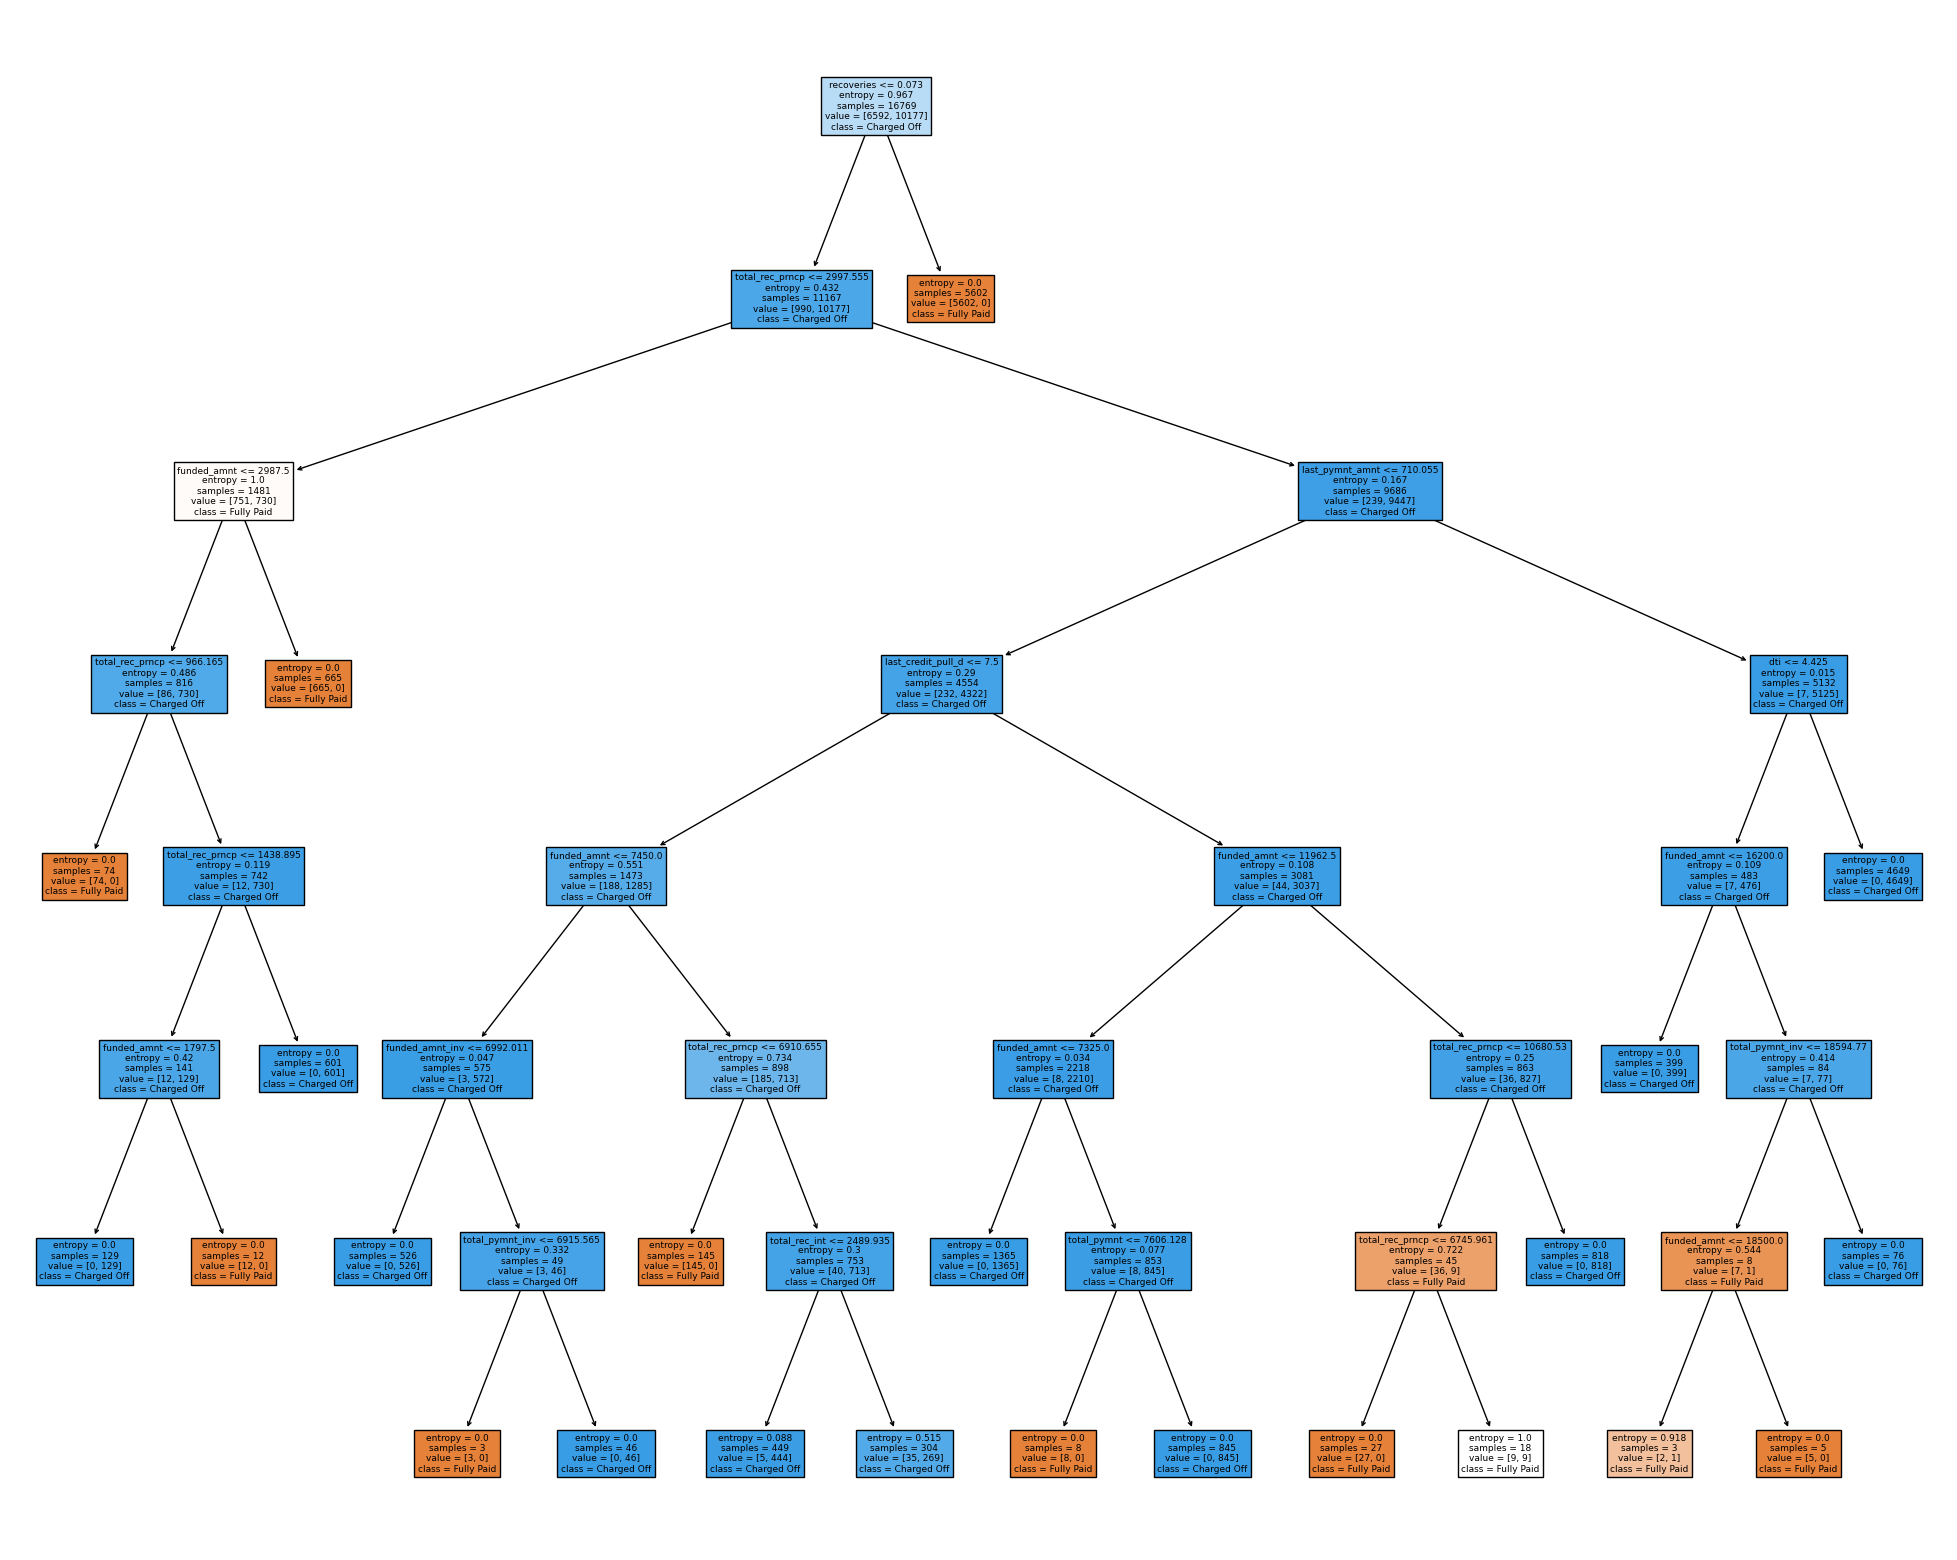

In [8]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=features,  
                   class_names=y_train_labeled.unique(),
                   filled=True)

### Testing Data performance: Precisiom, Recall, F1-Score

In [9]:
print("====== Testing Data Confusion Matrix ======")
print(confusion_matrix(y_test, y_pred_final))

====== Testing Data Confusion Matrix ======
[[1566   67]
 [   7 4969]]


In [10]:
print("====== Testing Data Classification Report ======")
print(classification_report(y_test, y_pred_final))

====== Testing Data Classification Report ======
              precision    recall  f1-score   support

 Charged Off       1.00      0.96      0.98      1633
  Fully Paid       0.99      1.00      0.99      4976

    accuracy                           0.99      6609
   macro avg       0.99      0.98      0.98      6609
weighted avg       0.99      0.99      0.99      6609



### Feature Importance

In [11]:
importance = clf.feature_importances_
for i,v in enumerate(importance):
 print(features[i],':', v)

loan_amnt : 0.0
funded_amnt : 0.0837856806135948
funded_amnt_inv : 0.0006740977734653195
term : 0.0
int_rate : 0.0
grade : 0.0
sub_grade : 0.0
emp_length : 0.0
home_ownership : 0.0
annual_inc : 0.0
verification_status : 0.0
issue_d : 0.0
purpose : 0.0
title : 0.0
addr_state : 0.0
dti : 0.001496270318387199
delinq_2yrs : 0.0
earliest_cr_line : 0.0
inq_last_6mths : 0.0
open_acc : 0.0
pub_rec : 0.0
revol_bal : 0.0
revol_util : 0.0
total_acc : 0.0
out_prncp : 0.0
out_prncp_inv : 0.0
total_pymnt : 0.00408746933865797
total_pymnt_inv : 0.002919322605302415
total_rec_prncp : 0.1684579374434814
total_rec_int : 0.0018313531251698924
total_rec_late_fee : 0.0
recoveries : 0.7119875083223864
collection_recovery_fee : 0.0
last_pymnt_d : 0.0
last_pymnt_amnt : 0.013616637429440408
last_credit_pull_d : 0.011143723030114171
collections_12_mths_ex_med : 0.0
pub_rec_bankruptcies : 0.0


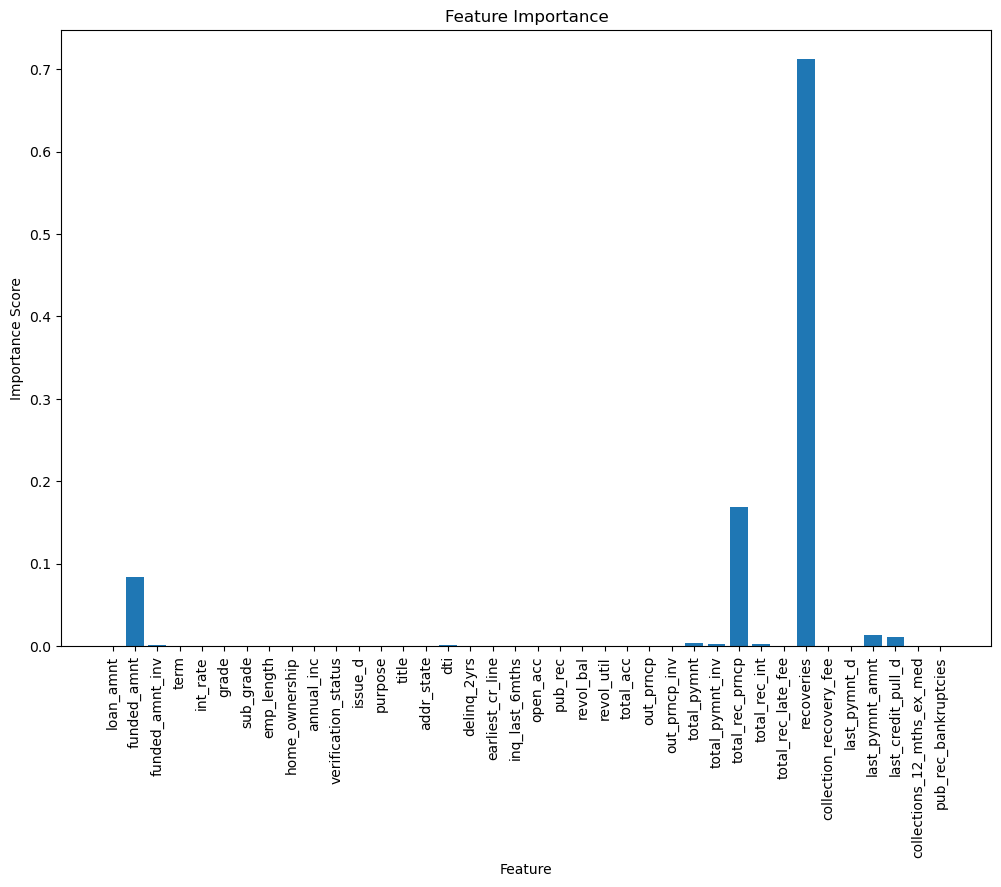

In [12]:
# plot feature importance
plt.figure(figsize=(12,8))
plt.bar(features, importance)
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.xticks(rotation=90)
plt.title("Feature Importance")
plt.show()

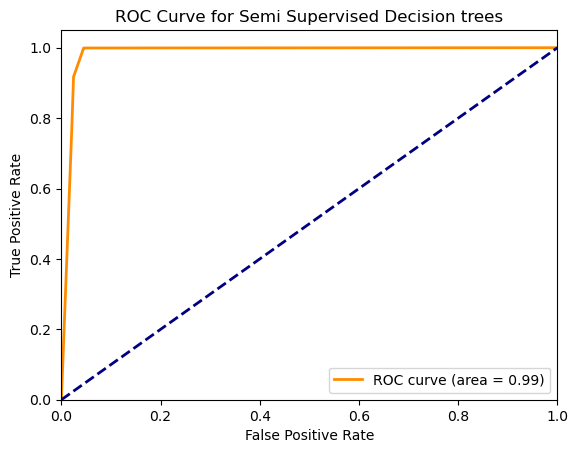

In [13]:
# Encode categorical columns in loan_test
X_test_encoded = encoder.transform(X_test)
y_test_encoded = np.where(y_test == 'Fully Paid', 1, 0)

# Predict labels for the final test set
y_pred_final = clf.predict(X_test_encoded)


# Compute ROC curve and area under the curve (AUC)
y_pred_proba = clf.predict_proba(X_test_encoded)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Semi Supervised Decision trees')
plt.legend(loc="lower right")
plt.show()

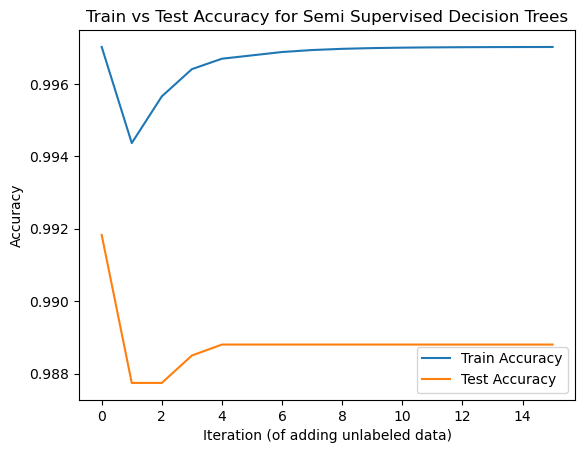

In [14]:
# Plot train vs test accuracy
plt.figure()
plt.plot(range(iteration), train_accuracy, label='Train Accuracy')
plt.plot(range(iteration), test_accuracy, label='Test Accuracy')
plt.xlabel('Iteration (of adding unlabeled data)')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy for Semi Supervised Decision Trees')
plt.legend()
plt.show()

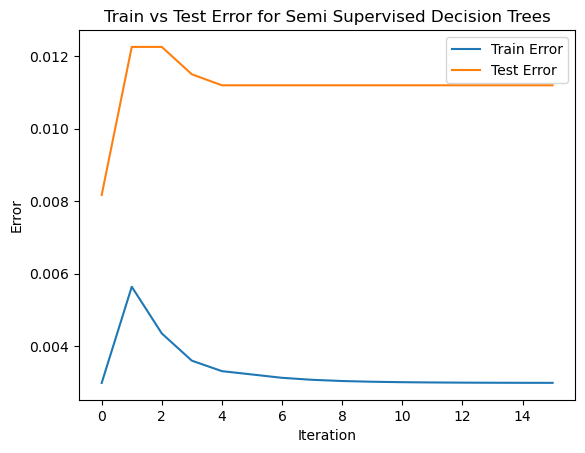

In [15]:
# Plot train vs test error
plt.figure()
plt.plot(range(iteration), train_error, label='Train Error')
plt.plot(range(iteration), test_error, label='Test Error')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Train vs Test Error for Semi Supervised Decision Trees')
plt.legend()
plt.show()


In [16]:
from sklearn.manifold import TSNE

In [17]:
tsne = TSNE(n_components=2, random_state=0)
X_labeled_tsne = tsne.fit_transform(X_train_labeled)

In [18]:
y_pred_encoded = np.where(y_train_pred == 'Fully Paid', 1, 0)

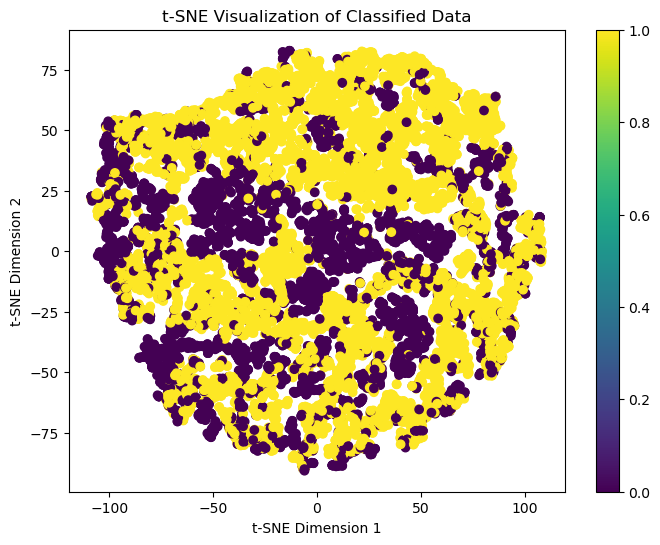

In [19]:
plt.figure(figsize=(8, 6))
plt.scatter(X_labeled_tsne[:, 0], X_labeled_tsne[:, 1], c=y_pred_encoded, cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Classified Data')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [20]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'max_features': [None, 0.5, 'sqrt']
}

In [21]:
clf = DecisionTreeClassifier(random_state=0)

In [22]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')


In [23]:
grid_search.fit(X_train_labeled, y_train_labeled)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10],
                         'max_features': [None, 0.5, 'sqrt'],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [24]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(best_params)
print(best_model)

{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2}
DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=3,
                       random_state=0)


In [25]:
accuracy = best_model.score(X_test_encoded, y_test_pred)

In [26]:
print(accuracy)

0.9962172794673929
